In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## import lifelines for survival analysis
from lifelines.plotting import add_at_risk_counts

In [2]:
mutation_energies = pd.read_csv("./3KMD_DDG.txt")
mutation_energies.head()

,Mutation,WT_energy,MUT_energy,DDG
0,RA273G,-9.31033,-8.68273,0.62760
1,RA273C,-9.15997,-8.67611,0.48386
2,RA273H,-9.34137,-8.28219,1.05918
3,RA273S,-9.31033,-8.67052,0.63981
4,RA273A,-9.31033,-8.66835,0.64198


In [3]:
## Get mutational energy for known lof mutant R273H
mutation_energies[mutation_energies["Mutation"] == "RA273H"]

,Mutation,WT_energy,MUT_energy,DDG
2,RA273H,-9.34137,-8.28219,1.05918


In [4]:
## Define our cutoff for high energy
high_energy = mutation_energies[mutation_energies["DDG"] > 0.5]["Mutation"]

In [5]:
## Convert mutations from DDG file to be compatible with TCGA mutations
start = high_energy.astype(str).str[0]
end = high_energy.astype(str).str[2:]

highenergy_mutation = ("p."+start+end).tolist()

In [6]:
## Patient mutation data from the TCGA pan cancer atlas (https://xenabrowser.net/datapages/?dataset=mc3.v0.2.8.PUBLIC.xena&host=https%3A%2F%2Fpancanatlas.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443)
patient_mutations = pd.read_csv("./PANCAN_data/mc3.v0.2.8.PUBLIC.xena", sep = "\t")

In [7]:
## Get TP53 mutations only
patient_mutations_TP53 = patient_mutations[patient_mutations["gene"] == "TP53"]
patient_mutations_TP53.head()

,sample,chr,start,end,reference,alt,gene,effect,Amino_Acid_Change,DNA_VAF,SIFT,PolyPhen
19,TCGA-02-0003-01,17,7577094,7577094,G,A,TP53,Missense_Mutation,p.R282W,0.43,deleterious(0),probably_damaging(0.997)
20,TCGA-02-0003-01,17,7578396,7578396,G,T,TP53,Missense_Mutation,p.H178Q,0.38,deleterious(0),probably_damaging(1)
80,TCGA-02-0033-01,17,7577538,7577538,C,T,TP53,Missense_Mutation,p.R248Q,0.26,deleterious(0),probably_damaging(1)
211,TCGA-02-0055-01,17,7578203,7578203,C,T,TP53,Missense_Mutation,p.V216M,0.61,deleterious(0),probably_damaging(1)
363,TCGA-02-2483-01,17,7577120,7577120,C,T,TP53,Missense_Mutation,p.R273H,0.90,tolerated(0.13),possibly_damaging(0.631)


In [8]:
## Get the patient ids for high + low energy mutations
patient_highenergy = patient_mutations_TP53[patient_mutations_TP53["Amino_Acid_Change"].isin(highenergy_mutation)]
patient_lowenergy = patient_mutations_TP53[~patient_mutations_TP53["sample"].isin(patient_highenergy["sample"].tolist())]

patient_highenergy_id = patient_highenergy["sample"].tolist()
patient_lowenergy_id = patient_lowenergy["sample"].tolist()

In [9]:
## Read in survival data from Xenabrowser: https://xenabrowser.net/datapages/?dataset=Survival_SupplementalTable_S1_20171025_xena_sp&host=https%3A%2F%2Fpancanatlas.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443
survival_data = pd.read_csv("./PANCAN_data/Survival_SupplementalTable_S1_20171025_xena_sp", sep = "\t")
survival_data = survival_data[survival_data["OS.time"].notna()]

In [10]:
survival_data.head()

,sample,_PATIENT,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-OR-A5J1-01,TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,NaN,Adrenocortical carcinoma- Usual Type,NaN,...,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
1,TCGA-OR-A5J2-01,TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,NaN,Adrenocortical carcinoma- Usual Type,NaN,...,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
2,TCGA-OR-A5J3-01,TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,NaN,Adrenocortical carcinoma- Usual Type,NaN,...,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
3,TCGA-OR-A5J4-01,TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,NaN,Adrenocortical carcinoma- Usual Type,NaN,...,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
4,TCGA-OR-A5J5-01,TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,NaN,Adrenocortical carcinoma- Usual Type,NaN,...,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN


In [11]:
high = (survival_data["sample"].isin(patient_highenergy_id))
low = (survival_data["sample"].isin(patient_lowenergy_id))

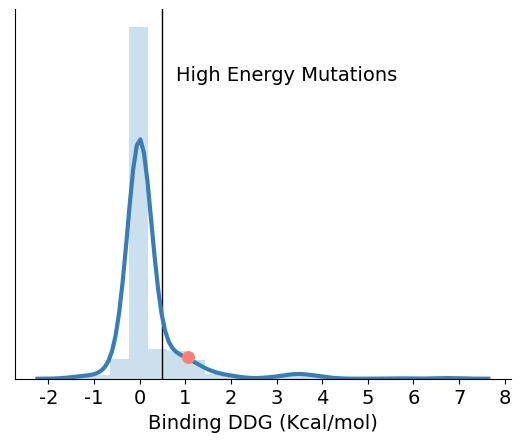

In [12]:
g = sns.distplot(mutation_energies["DDG"], norm_hist=True, bins = 20, kde = False, color = sns.color_palette("Set3")[4])
g2 = sns.kdeplot(mutation_energies["DDG"], bw = 0.25, color = sns.color_palette("Set1")[1], alpha = 1, legend=False
                ,lw = 3)

g3 = plt.scatter(1.05918, 0.11, alpha = 1, s = 70, color = sns.color_palette("Set3")[3], zorder = 2)
sns.despine()

g.set_yticks([])
g.set_xlabel("Binding DDG (Kcal/mol)", size = 14)
g.set_xticks([-2,-1,0,1,2,3,4,5,6,7,8])
g.set_xticklabels([-2, -1, 0,1,2,3,4,5,6,7,8], size = 14)

g.axvline(0.5, c = "k", lw = 1, zorder = 1)
g.annotate("High Energy Mutations", (0.8, 1.5), size = 14)

plt.savefig("TP53_DNAbinding_distributions.pdf")
plt.show()

## Logrank Test

In [13]:
from lifelines.statistics import logrank_test

pvalue = logrank_test(survival_data[low]["OS.time"],survival_data[high]["OS.time"]
                      ,survival_data[low]["OS"] ,survival_data[high]["OS"], alpha=.95)

pvalue.print_summary()

/Users/davidshorthouse/anaconda3/lib/python3.8/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.48 0.02      5.70

## Kaplan Meier

In [14]:
from lifelines import KaplanMeierFitter


kmf = KaplanMeierFitter()

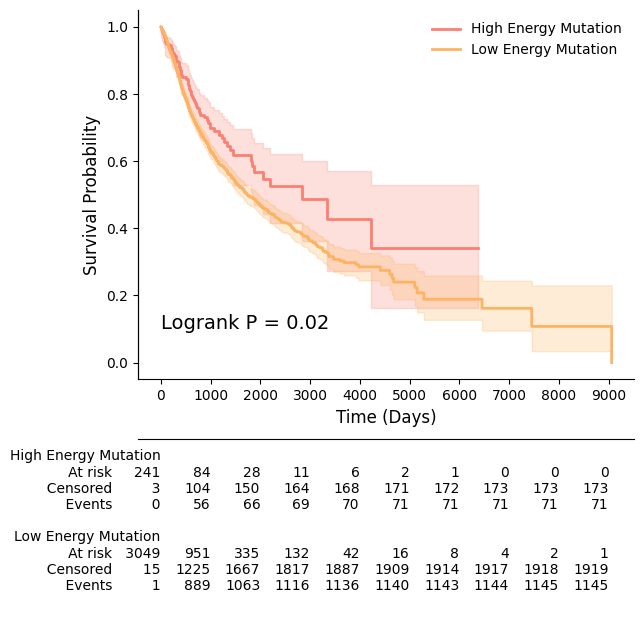

In [15]:
ax = plt.subplot(111)

kmf_high = KaplanMeierFitter()
ax = kmf_high.fit(survival_data[high]["OS.time"]
                  , event_observed = survival_data[high]["OS"]
                  , label = "High Energy Mutation").plot_survival_function(ax=ax, color = sns.color_palette("Set3")[3], linewidth = 2)

kmf_low = KaplanMeierFitter()
ax = kmf_low.fit(survival_data[low]["OS.time"]
                  , event_observed = survival_data[low]["OS"]
                  , label = "Low Energy Mutation").plot_survival_function(ax=ax, color = sns.color_palette("Set3")[5], linewidth = 2)

ax.set_xticks([0,1000, 2000, 3000,4000, 5000,6000,7000, 8000,9000])

add_at_risk_counts(kmf_high, kmf_low, ax=ax)
#plt.tight_layout()

ax.set_ylabel("Survival Probability", size = 12)
ax.set_xlabel("Time (Days)", size = 12)
ax.legend(frameon=False)

ax.annotate("Logrank P = 0.02", (0, 0.1), size = 14)

sns.despine()

plt.savefig("Survival_analysis_TP53_mutationtypes.pdf", bbox_inches="tight")
plt.show()

In [16]:
import numpy as np

In [17]:
np.percentile(mutation_energies["DDG"], 92)

1.039225999999999